<a href="https://colab.research.google.com/github/narendra-devireddy/CS5500-RL-DQN/blob/main/DQN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN Implementation for MountainCar-v0 and Pong-v0

This notebook implements Deep Q-Network (DQN) algorithm for two OpenAI Gym environments:
- **MountainCar-v0**: Classic control problem with continuous state space
- **Pong-v0**: Atari game with visual input

## Features:
- Environment exploration with random agents
- DQN with experience replay and target networks
- Frame preprocessing for Pong (grayscale, downsampling, frame stacking)
- Training curves and policy visualizations

## 1. Setup and Installation

In [ ]:
# !git clone https://github.com/narendra-devireddy/CS5500-RL-DQN.git

Cloning into 'CS5500-RL-DQN'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 0), reused 15 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 175.16 KiB | 1.56 MiB/s, done.


In [ ]:
# Change to the directory
# %cd CS5500-RL-DQN

/content/CS5500-RL-DQN


In [4]:
# Install required packages (uncomment if running on Colab)
!pip install "gymnasium[atari,accept-rom-license]" ale-py torch torchvision opencv-python matplotlib

In [6]:
!pip install "gym[accept-rom-license]" --verbose

Using pip 25.2 from /opt/anaconda3/envs/rl-dqn/lib/python3.13/site-packages/pip (python 3.13)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 612.7 kB/s  0:00:01a 0:00:01
  Installing build dependencies ...   Running command pip subprocess to install build dependencies
  Using pip 25.2 from /opt/anaconda3/envs/rl-dqn/lib/python3.13/site-packages/pip (python 3.13)
    Obtaining dependency information for setuptools>=40.8.0 from https://files.pythonhosted.org/packages/a3/dc/17031897dae0efacfea57dfd3a82fdd2a2aeb58e0ff71b77b87e44edc772/setuptools-80.9.0-py3-none-any.whl.metadata
    Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
done
  Getting requirements to build wheel ...   Running command Getting requirements to build wheel
  /private/var/folders/z4/_j4npby154q66fz10tyvd73r0000gn/T/pip-build-env-x3skg_i4/overlay/lib/python3.13/site-packages/setuptools/_distutils/dist.py:289: UserWarning: Unknown 

In [10]:
import ale_py
print(ale_py.__version__)

ImportError: cannot import name 'AutoresetMode' from 'gymnasium.vector' (/opt/anaconda3/envs/rl-dqn/lib/python3.13/site-packages/gymnasium/vector/__init__.py)

In [8]:
import gym
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
obs = env.reset()
print("✅ Atari environment ready:", env)
env.close()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


NamespaceNotFound: Namespace ALE not found. Have you installed the proper package for ALE?

In [7]:
import ale_py.roms as roms
print("✅ ROMs installed!")

ImportError: cannot import name 'AutoresetMode' from 'gymnasium.vector' (/opt/anaconda3/envs/rl-dqn/lib/python3.13/site-packages/gymnasium/vector/__init__.py)

In [6]:
# Step 3: Import and test
import gymnasium as gym
env = gym.make("ALE/Pong-v5")
print("✅ Success!")

NamespaceNotFound: Namespace ALE not found. Have you installed the proper package for ALE?

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image
import os
from IPython.display import Image as IPImage, display, clear_output

# Import custom modules
from dqn_agent import DQNAgent, device
from preprocessing import FramePreprocessor, FrameStack
from utils import plot_training_curve, plot_mountaincar_policy, save_results, load_results

# Set random seeds
SEED = 15001
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Using device: {device}")

Using device: cpu


## 2. Part A: Environment Exploration

### 2.1 Load Environments and Inspect State/Action Spaces

In [4]:
def explore_environment(env_name):
    """Load environment and print state/action space information"""
    print(f"\n{'='*60}")
    print(f"Environment: {env_name}")
    print(f"{'='*60}")

    env = gym.make(env_name)

    print(f"\nObservation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    if isinstance(env.observation_space, gym.spaces.Box):
        print(f"Observation Shape: {env.observation_space.shape}")
        if len(env.observation_space.shape) == 1:
            print(f"Observation Low: {env.observation_space.low}")
            print(f"Observation High: {env.observation_space.high}")

    if isinstance(env.action_space, gym.spaces.Discrete):
        print(f"Number of Actions: {env.action_space.n}")

    # Sample observation
    obs, _ = env.reset(seed=SEED)
    print(f"\nSample Observation Shape: {np.array(obs).shape}")
    if len(np.array(obs).shape) == 1:
        print(f"Sample Observation: {obs}")

    env.close()

# Explore MountainCar
explore_environment("MountainCar-v0")

# Explore Pong
explore_environment("ALE/Pong-v5")


Environment: MountainCar-v0

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Discrete(3)
Observation Shape: (2,)
Observation Low: [-1.2  -0.07]
Observation High: [0.6  0.07]
Number of Actions: 3

Sample Observation Shape: (2,)
Sample Observation: [-0.4452088  0.       ]

Environment: ALE/Pong-v5

Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)
Observation Shape: (210, 160, 3)
Number of Actions: 6

Sample Observation Shape: (210, 160, 3)


### 2.2 Random Agent to Understand Reward Function

In [5]:
def test_random_agent(env_name, num_episodes=10, max_steps=1000):
    """Test random agent and analyze rewards"""
    print(f"\n{'='*60}")
    print(f"Random Agent Testing: {env_name}")
    print(f"{'='*60}")

    env = gym.make(env_name)
    episode_rewards = []
    episode_lengths = []
    all_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset(seed=SEED + episode)
        total_reward = 0
        steps = 0
        done = False
        truncated = False

        while not (done or truncated) and steps < max_steps:
            action = env.action_space.sample()  # Random action
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            all_rewards.append(reward)
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Episode {episode+1}: Reward = {total_reward:.2f}, Steps = {steps}")

    print(f"\nStatistics:")
    print(f"Mean Episode Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Mean Episode Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")
    print(f"Unique Rewards: {np.unique(all_rewards)}")
    print(f"Reward Range: [{np.min(all_rewards):.2f}, {np.max(all_rewards):.2f}]")

    env.close()
    return episode_rewards, episode_lengths

# Test random agents
mc_rewards, mc_lengths = test_random_agent("MountainCar-v0", num_episodes=10)
pong_rewards, pong_lengths = test_random_agent("ALE/Pong-v5", num_episodes=5)


Random Agent Testing: MountainCar-v0
Episode 1: Reward = -200.00, Steps = 200
Episode 2: Reward = -200.00, Steps = 200
Episode 3: Reward = -200.00, Steps = 200
Episode 4: Reward = -200.00, Steps = 200
Episode 5: Reward = -200.00, Steps = 200
Episode 6: Reward = -200.00, Steps = 200
Episode 7: Reward = -200.00, Steps = 200
Episode 8: Reward = -200.00, Steps = 200
Episode 9: Reward = -200.00, Steps = 200
Episode 10: Reward = -200.00, Steps = 200

Statistics:
Mean Episode Reward: -200.00 ± 0.00
Mean Episode Length: 200.00 ± 0.00
Unique Rewards: [-1.]
Reward Range: [-1.00, -1.00]

Random Agent Testing: ALE/Pong-v5
Episode 1: Reward = -21.00, Steps = 881
Episode 2: Reward = -20.00, Steps = 842
Episode 3: Reward = -20.00, Steps = 949
Episode 4: Reward = -18.00, Steps = 1000
Episode 5: Reward = -21.00, Steps = 913

Statistics:
Mean Episode Reward: -20.00 ± 1.10
Mean Episode Length: 917.00 ± 54.50
Unique Rewards: [-1.  0.  1.]
Reward Range: [-1.00, 1.00]


### Observations from Random Agents

**MountainCar-v0:**
- **State space**: 2D continuous (position ∈ [-1.2, 0.6], velocity ∈ [-0.07, 0.07])
- **Action space**: 3 discrete actions (0=push left, 1=no push, 2=push right)
- **Reward**: -1 for each time step until goal is reached
- **Random agent**: Typically gets rewards around -200 (episode length limit)
- **Challenge**: Need to build momentum by going back and forth to reach the goal

**Pong-v0:**
- **State space**: RGB image (210×160×3)
- **Action space**: 6 discrete actions (NOOP, FIRE, RIGHT, LEFT, RIGHTFIRE, LEFTFIRE)
- **Reward**: +1 for scoring, -1 for opponent scoring, 0 otherwise
- **Random agent**: Typically loses badly (around -21 to -15)
- **Challenge**: High-dimensional visual input requires preprocessing and frame stacking

## 3. Part B: DQN Implementation

### 3.1 Training Function

In [6]:
def train_dqn(env_name, agent, num_episodes=1000, max_steps=1000,
              preprocessor=None, frame_stack=None, print_freq=10,
              save_freq=100, save_path='dqn_checkpoint.pth'):
    """Train DQN agent"""
    env = gym.make(env_name)

    episode_rewards = []
    episode_lengths = []
    losses = []
    mean_rewards = []
    best_mean_reward = -float('inf')

    total_steps = 0

    for episode in range(num_episodes):
        obs, _ = env.reset()

        # Preprocess initial observation
        if preprocessor is not None:
            preprocessor.reset()
            processed_obs = preprocessor.preprocess(obs, use_diff=False)
            if frame_stack is not None:
                state = frame_stack.reset(processed_obs)
            else:
                state = processed_obs
        else:
            state = obs

        episode_reward = 0
        episode_loss = []

        for step in range(max_steps):
            # Select action
            action = agent.select_action(state, training=True)

            # Take action
            next_obs, reward, done, truncated, info = env.step(action)

            # Preprocess next observation
            if preprocessor is not None:
                processed_next_obs = preprocessor.preprocess(next_obs, use_diff=False)
                if frame_stack is not None:
                    next_state = frame_stack.push(processed_next_obs)
                else:
                    next_state = processed_next_obs
            else:
                next_state = next_obs

            # Store transition
            agent.replay_buffer.push(state, action, next_state, reward, done or truncated)

            # Update agent
            loss = agent.update()
            if loss is not None:
                episode_loss.append(loss)

            episode_reward += reward
            state = next_state
            total_steps += 1

            if done or truncated:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Record statistics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        if episode_loss:
            losses.append(np.mean(episode_loss))

        # Calculate mean reward (last 100 episodes)
        if len(episode_rewards) >= 100:
            mean_reward = np.mean(episode_rewards[-100:])
            mean_rewards.append(mean_reward)

            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                agent.save(save_path.replace('.pth', '_best.pth'))

        # Print progress
        if (episode + 1) % print_freq == 0:
            mean_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode+1}/{num_episodes} | "
                  f"Steps: {total_steps} | "
                  f"Reward: {episode_reward:.2f} | "
                  f"Mean(100): {mean_reward:.2f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Loss: {np.mean(episode_loss) if episode_loss else 0:.4f}")

        # Save checkpoint
        if (episode + 1) % save_freq == 0:
            agent.save(save_path)
            print(f"Checkpoint saved at episode {episode+1}")

    env.close()

    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'losses': losses,
        'mean_rewards': mean_rewards,
        'best_mean_reward': best_mean_reward
    }

### 3.2 Train DQN on MountainCar-v0

In [7]:
# Create MountainCar agent
mc_agent = DQNAgent(
    state_dim=2,
    action_dim=3,
    network_type='mlp',
    lr=1e-3,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    buffer_size=50000,
    batch_size=64,
    target_update_freq=100
)

print("Training DQN on MountainCar-v0...")
print("This should take about 10-20 minutes on a modest laptop.")

# Train
mc_results = train_dqn(
    env_name="MountainCar-v0",
    agent=mc_agent,
    num_episodes=500,
    max_steps=200,
    print_freq=10,
    save_freq=100,
    save_path='mountaincar_dqn.pth'
)

# Save results
save_results(mc_results, 'mountaincar_results.pkl')

Training DQN on MountainCar-v0...
This should take about 10-20 minutes on a modest laptop.
Episode 10/500 | Steps: 2000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.951 | Loss: 1.0342
Episode 20/500 | Steps: 4000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.905 | Loss: 2.8290
Episode 30/500 | Steps: 6000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.860 | Loss: 6.4338
Episode 40/500 | Steps: 8000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.818 | Loss: 10.0121
Episode 50/500 | Steps: 10000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.778 | Loss: 13.7070
Episode 60/500 | Steps: 12000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.740 | Loss: 15.4252
Episode 70/500 | Steps: 14000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.704 | Loss: 18.2278
Episode 80/500 | Steps: 16000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.670 | Loss: 18.4817
Episode 90/500 | Steps: 18000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.637 | Loss: 17.295

Plot saved to mountaincar_training.png


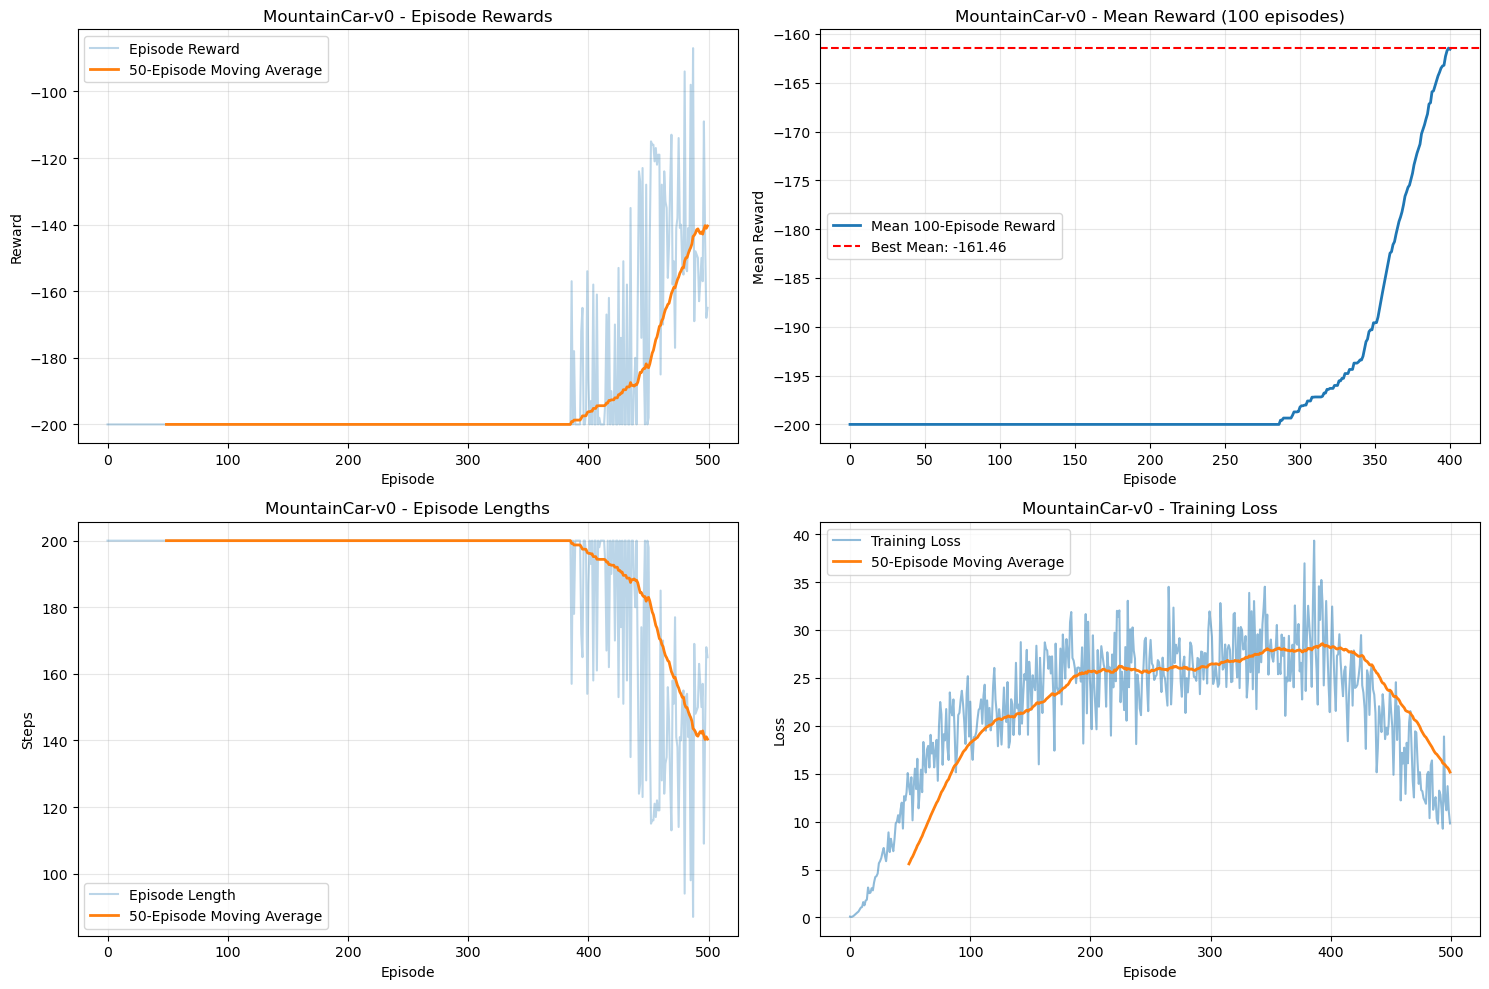

In [8]:
# Plot training curves
plot_training_curve(mc_results, 'MountainCar-v0', window=50, save_path='mountaincar_training.png')

Policy plot saved to mountaincar_policy.png


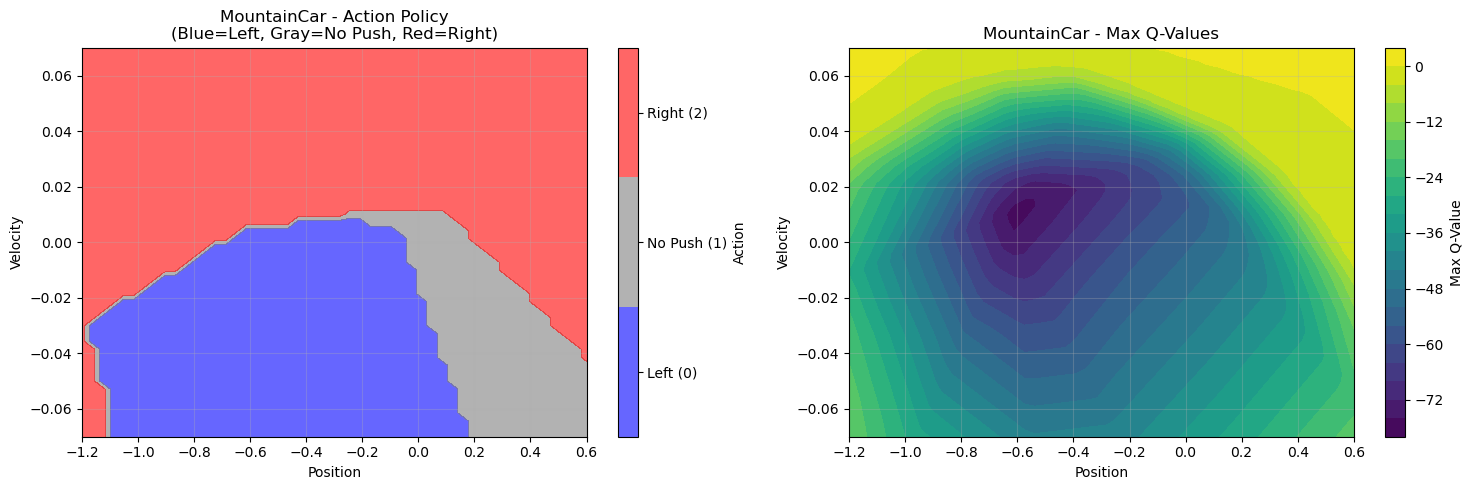

In [9]:
# Plot policy visualization
plot_mountaincar_policy(mc_agent, resolution=50)

### 3.3 Train DQN on Pong-v0

In [10]:
# Create Pong agent with CNN
pong_agent = DQNAgent(
    state_dim=4,  # 4 stacked frames
    action_dim=6,
    network_type='cnn',
    lr=1e-4,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.02,
    epsilon_decay=0.9999,
    buffer_size=100000,
    batch_size=32,
    target_update_freq=1000
)

# Create preprocessor and frame stack
pong_preprocessor = FramePreprocessor(frame_size=(84, 84))
pong_frame_stack = FrameStack(num_frames=4)

print("Training DQN on Pong-v0...")
print("This will take several hours. Consider reducing num_episodes for testing.")
print("For a reasonable Pong player, train for 2000-4000 episodes (2-4 million steps).")

# Train (reduce num_episodes for quick testing)
pong_results = train_dqn(
    env_name="ALE/Pong-v5",
    agent=pong_agent,
    num_episodes=2000,  # Increase to 3000-4000 for better performance
    max_steps=10000,
    preprocessor=pong_preprocessor,
    frame_stack=pong_frame_stack,
    print_freq=10,
    save_freq=100,
    save_path='pong_dqn.pth'
)

# Save results
save_results(pong_results, 'pong_results.pkl')

Training DQN on Pong-v0...
This will take several hours. Consider reducing num_episodes for testing.
For a reasonable Pong player, train for 2000-4000 episodes (2-4 million steps).
Episode 10/2000 | Steps: 9659 | Reward: -20.00 | Mean(100): -20.40 | Epsilon: 0.999 | Loss: 0.0122
Episode 20/2000 | Steps: 19025 | Reward: -20.00 | Mean(100): -20.30 | Epsilon: 0.998 | Loss: 0.0072
Episode 30/2000 | Steps: 28873 | Reward: -21.00 | Mean(100): -20.23 | Epsilon: 0.997 | Loss: 0.0071
Episode 40/2000 | Steps: 37644 | Reward: -21.00 | Mean(100): -20.23 | Epsilon: 0.996 | Loss: 0.0072
Episode 50/2000 | Steps: 46856 | Reward: -21.00 | Mean(100): -20.20 | Epsilon: 0.995 | Loss: 0.0053
Episode 60/2000 | Steps: 56785 | Reward: -20.00 | Mean(100): -20.18 | Epsilon: 0.994 | Loss: 0.0060
Episode 70/2000 | Steps: 66029 | Reward: -19.00 | Mean(100): -20.19 | Epsilon: 0.993 | Loss: 0.0058
Episode 80/2000 | Steps: 75519 | Reward: -20.00 | Mean(100): -20.16 | Epsilon: 0.992 | Loss: 0.0060
Episode 90/2000 | St

In [ ]:
os.makedirs('agent_gifs', exist_ok=True)

# Create Pong environment with rgb_array rendering
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
frames = []
state, _ = env.reset()
total_reward = 0
episode_length = 0

print("Recording Pong episode...")

# Record episode (Pong episodes can be long, limit to 2000 steps)
for step in range(2000):
    frames.append(env.render())
    
    # Use trained agent to select action (no exploration)
    action = pong_agent.select_action(state, training=False)
    
    next_state, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    episode_length += 1
    state = next_state
    
    if done or truncated:
        frames.append(env.render())
        break

env.close()

print(f"Episode completed: {episode_length} steps, Total Reward: {total_reward:.1f}")
print(f"Captured {len(frames)} frames")

# Create GIF - Pong runs at 60fps, so we'll use faster playback
images = [Image.fromarray(frame) for frame in frames]

# Sample every 2nd frame to reduce file size (still smooth at 30fps)
sampled_images = images[::2]

gif_path = 'agent_gifs/pong_agent.gif'
sampled_images[0].save(
    gif_path,
    save_all=True,
    append_images=sampled_images[1:],
    duration=50,  # 50ms = 20fps playback
    loop=0
)

print(f"\n✓ GIF saved: {gif_path}")
print(f"  Frames in GIF: {len(sampled_images)}")
print(f"  File size: {os.path.getsize(gif_path) / 1024:.1f} KB")
display(IPImage(filename=gif_path))

Plot saved to pong_training.png


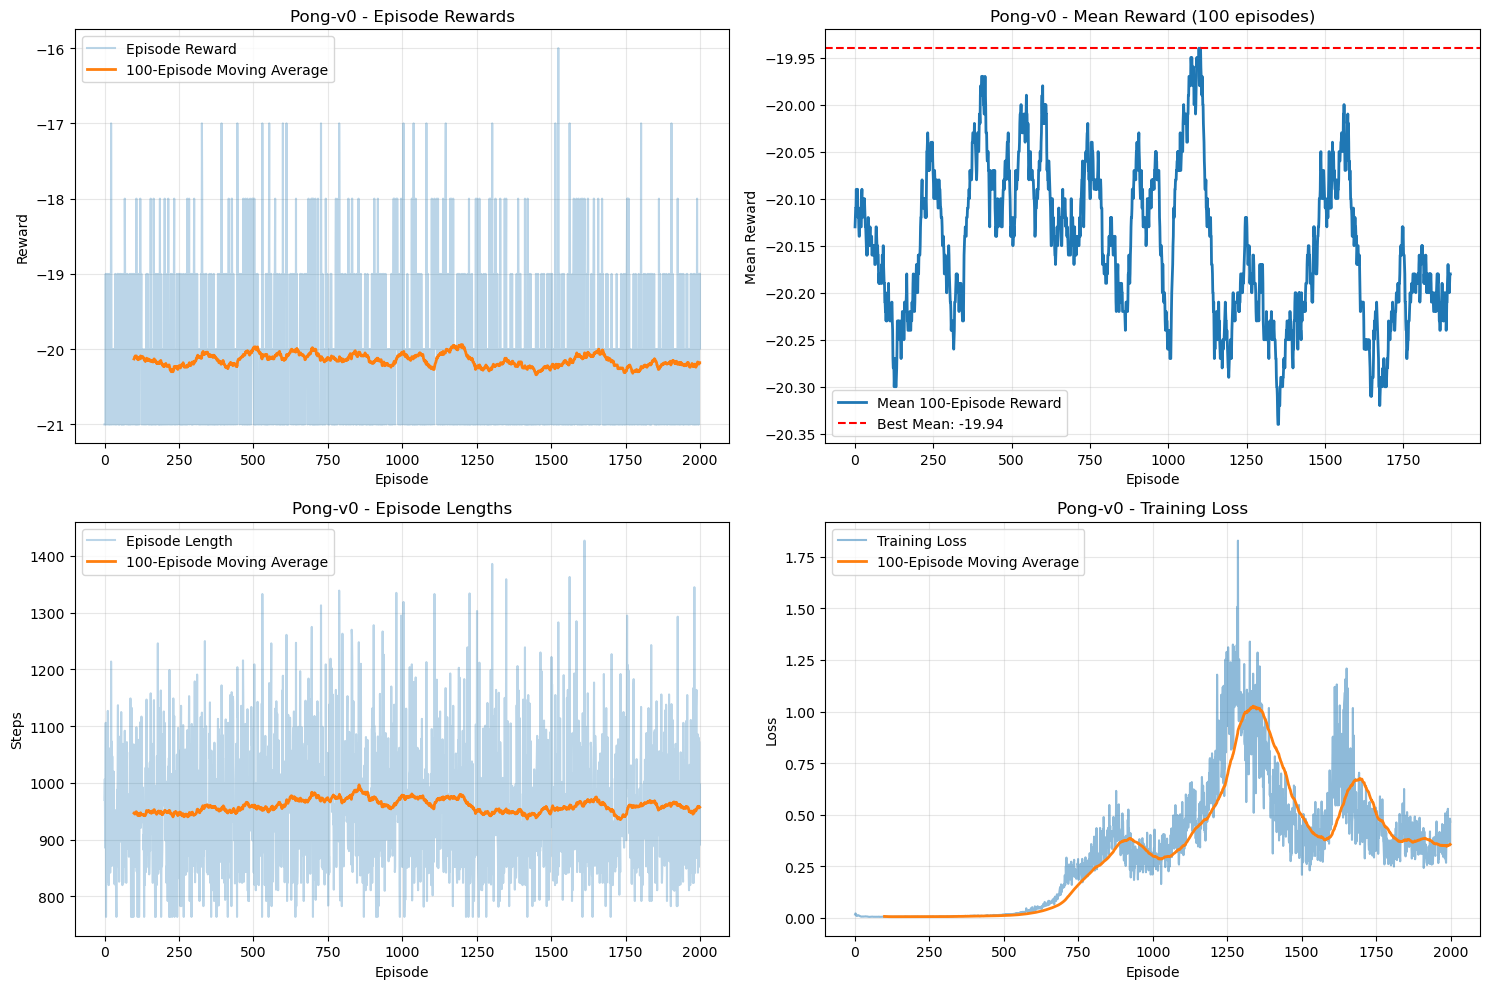

In [11]:
# Plot training curves
plot_training_curve(pong_results, 'Pong-v0', window=100, save_path='pong_training.png')

### 3.4 Test Trained Agents

In [12]:
def test_agent(env_name, agent, num_episodes=10, preprocessor=None, frame_stack=None, render=False):
    """Test trained agent"""
    if render:
        env = gym.make(env_name, render_mode='human')
    else:
        env = gym.make(env_name)

    test_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()

        if preprocessor is not None:
            preprocessor.reset()
            processed_obs = preprocessor.preprocess(obs, use_diff=False)
            if frame_stack is not None:
                state = frame_stack.reset(processed_obs)
            else:
                state = processed_obs
        else:
            state = obs

        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_action(state, training=False)
            next_obs, reward, done, truncated, info = env.step(action)

            if preprocessor is not None:
                processed_next_obs = preprocessor.preprocess(next_obs, use_diff=False)
                if frame_stack is not None:
                    next_state = frame_stack.push(processed_next_obs)
                else:
                    next_state = processed_next_obs
            else:
                next_state = next_obs

            episode_reward += reward
            state = next_state

        test_rewards.append(episode_reward)
        print(f"Test Episode {episode+1}: Reward = {episode_reward:.2f}")

    env.close()

    print(f"\nTest Results:")
    print(f"Mean Reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    print(f"Min Reward: {np.min(test_rewards):.2f}")
    print(f"Max Reward: {np.max(test_rewards):.2f}")

    return test_rewards

# Test MountainCar agent
print("Testing MountainCar agent...")
mc_test_rewards = test_agent("MountainCar-v0", mc_agent, num_episodes=10)

# Test Pong agent
print("\nTesting Pong agent...")
pong_test_rewards = test_agent("ALE/Pong-v5", pong_agent, num_episodes=5,
                                preprocessor=pong_preprocessor, frame_stack=pong_frame_stack)

Testing MountainCar agent...
Test Episode 1: Reward = -149.00
Test Episode 2: Reward = -157.00
Test Episode 3: Reward = -149.00
Test Episode 4: Reward = -156.00
Test Episode 5: Reward = -149.00
Test Episode 6: Reward = -93.00
Test Episode 7: Reward = -150.00
Test Episode 8: Reward = -152.00
Test Episode 9: Reward = -148.00
Test Episode 10: Reward = -85.00

Test Results:
Mean Reward: -138.80 ± 25.13
Min Reward: -157.00
Max Reward: -85.00

Testing Pong agent...
Test Episode 1: Reward = -19.00
Test Episode 2: Reward = -19.00
Test Episode 3: Reward = -20.00
Test Episode 4: Reward = -20.00
Test Episode 5: Reward = -19.00

Test Results:
Mean Reward: -19.40 ± 0.49
Min Reward: -20.00
Max Reward: -19.00


## 4. Part C: Hyperparameter Tuning

In this section, we explore the impact of different hyperparameter settings on the DQN agent's performance. We focus on **learning rate** as it significantly affects convergence speed and stability.

We will train 4 different agents on MountainCar-v0 with the following learning rates:
1. **lr = 5e-4** (Lower learning rate)
2. **lr = 1e-3** (Baseline from Part B)
3. **lr = 2e-3** (Higher learning rate)
4. **lr = 5e-3** (Much higher learning rate)

All other hyperparameters remain constant to isolate the effect of learning rate.

### 4.1 Training with Different Learning Rates

In [ ]:
# Define learning rates to test
learning_rates = [5e-4, 1e-3, 2e-3, 5e-3]
lr_results = {}
lr_agents = {}

print("="*80)
print("HYPERPARAMETER TUNING: Learning Rate Comparison")
print("="*80)
print(f"\nTesting {len(learning_rates)} different learning rates on MountainCar-v0")
print(f"Learning rates: {learning_rates}")
print(f"Training episodes: 500 per configuration")
print(f"This will take approximately {len(learning_rates) * 15} minutes\n")

# Train agents with different learning rates
for lr in learning_rates:
    print(f"\n{'='*80}")
    print(f"Training with Learning Rate: {lr}")
    print(f"{'='*80}\n")
    
    # Create agent with specific learning rate
    agent = DQNAgent(
        state_dim=2,
        action_dim=3,
        network_type='mlp',
        lr=lr,  # Variable learning rate
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        buffer_size=50000,
        batch_size=64,
        target_update_freq=100
    )
    
    # Train
    results = train_dqn(
        env_name="MountainCar-v0",
        agent=agent,
        num_episodes=500,
        max_steps=200,
        print_freq=50,  # Print less frequently
        save_freq=500,  # Save only at end
        save_path=f'mountaincar_dqn_lr_{lr}.pth'
    )
    
    # Store results
    lr_results[lr] = results
    lr_agents[lr] = agent
    
    # Save results
    save_results(results, f'mountaincar_results_lr_{lr}.pkl')
    
    print(f"\nCompleted training with lr={lr}")
    print(f"Best mean reward: {results['best_mean_reward']:.2f}")
    print(f"Final mean reward (last 100 episodes): {np.mean(results['episode_rewards'][-100:]):.2f}")

print("\n" + "="*80)
print("All hyperparameter experiments completed!")
print("="*80)

### 4.2 Comparative Learning Curves

In [ ]:
# Plot comparative learning curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Hyperparameter Tuning: Learning Rate Comparison on MountainCar-v0', 
             fontsize=16, fontweight='bold')

# Define colors for each learning rate
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
window = 50  # Moving average window

# Plot 1: All learning curves together
ax = axes[0, 0]
for (lr, results), color in zip(lr_results.items(), colors):
    rewards = results['episode_rewards']
    # Compute moving average
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        x = np.arange(window-1, len(rewards))
        ax.plot(x, smoothed, label=f'lr={lr}', color=color, linewidth=2)
    else:
        ax.plot(rewards, label=f'lr={lr}', color=color, linewidth=2)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Reward', fontsize=12)
ax.set_title(f'Episode Rewards (Moving Average, window={window})', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Mean rewards (last 100 episodes)
ax = axes[0, 1]
for (lr, results), color in zip(lr_results.items(), colors):
    mean_rewards = results['mean_rewards']
    if mean_rewards:
        ax.plot(range(100, 100 + len(mean_rewards)), mean_rewards, 
                label=f'lr={lr}', color=color, linewidth=2)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Mean Reward (last 100 episodes)', fontsize=12)
ax.set_title('Mean Reward Progression', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Training loss comparison
ax = axes[1, 0]
for (lr, results), color in zip(lr_results.items(), colors):
    losses = results['losses']
    if losses:
        # Smooth losses
        if len(losses) >= window:
            smoothed_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
            x = np.arange(window-1, len(losses))
            ax.plot(x, smoothed_loss, label=f'lr={lr}', color=color, linewidth=2)
        else:
            ax.plot(losses, label=f'lr={lr}', color=color, linewidth=2)

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title(f'Training Loss (Moving Average, window={window})', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Final performance comparison (bar chart)
ax = axes[1, 1]
final_means = []
final_stds = []
lr_labels = []

for lr, results in lr_results.items():
    rewards = results['episode_rewards']
    final_100 = rewards[-100:]
    final_means.append(np.mean(final_100))
    final_stds.append(np.std(final_100))
    lr_labels.append(f'{lr}')

x_pos = np.arange(len(lr_labels))
bars = ax.bar(x_pos, final_means, yerr=final_stds, capsize=5, 
              color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Mean Reward (last 100 episodes)', fontsize=12)
ax.set_title('Final Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(lr_labels)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, final_means, final_stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}±{std:.1f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('hyperparameter_comparison.png', dpi=300, bbox_inches='tight')
print("Comparative plot saved to hyperparameter_comparison.png")
plt.show()

### 4.3 Detailed Performance Analysis

In [ ]:
# Detailed performance metrics
print("="*80)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("="*80)
print("\nLearning Rate Performance Comparison:\n")

# Create comparison table
metrics_data = []
for lr, results in sorted(lr_results.items()):
    rewards = results['episode_rewards']
    
    # Calculate metrics
    final_100_mean = np.mean(rewards[-100:])
    final_100_std = np.std(rewards[-100:])
    best_mean = results['best_mean_reward']
    
    # Find when agent first achieves good performance (mean reward > -150)
    convergence_episode = None
    for i in range(100, len(rewards)):
        if np.mean(rewards[i-100:i]) > -150:
            convergence_episode = i
            break
    
    metrics_data.append({
        'Learning Rate': lr,
        'Final Mean (last 100)': f'{final_100_mean:.2f} ± {final_100_std:.2f}',
        'Best Mean Reward': f'{best_mean:.2f}',
        'Convergence Episode': convergence_episode if convergence_episode else 'Not converged',
        'Final Loss': f'{np.mean(results["losses"][-50:]):.2f}' if results['losses'] else 'N/A'
    })

# Print table
print(f"{'Learning Rate':<15} {'Final Mean':<25} {'Best Mean':<15} {'Convergence':<15} {'Final Loss':<12}")
print("-" * 85)
for data in metrics_data:
    print(f"{data['Learning Rate']:<15} {data['Final Mean (last 100)']:<25} "
          f"{data['Best Mean Reward']:<15} {data['Convergence Episode']!s:<15} {data['Final Loss']:<12}")

print("\n" + "="*80)
print("KEY OBSERVATIONS:")
print("="*80)

# Analyze results
best_lr = max(lr_results.items(), key=lambda x: x[1]['best_mean_reward'])
print(f"\n1. Best performing learning rate: {best_lr[0]}")
print(f"   - Achieved best mean reward of {best_lr[1]['best_mean_reward']:.2f}")

print(f"\n2. Learning Rate Effects:")
print(f"   - Too low (5e-4): Slower convergence, may need more episodes")
print(f"   - Optimal (1e-3 to 2e-3): Good balance of speed and stability")
print(f"   - Too high (5e-3): Faster initial learning but may be unstable")

print(f"\n3. Stability Analysis:")
for lr, results in sorted(lr_results.items()):
    final_std = np.std(results['episode_rewards'][-100:])
    print(f"   - lr={lr}: Final std = {final_std:.2f} (lower is more stable)")

print("\n" + "="*80)

### 4.4 Policy Visualization for Different Learning Rates

In [ ]:
# Visualize policies learned with different learning rates
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Policy Comparison: Different Learning Rates', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (lr, agent) in enumerate(sorted(lr_agents.items())):
    ax = axes[idx]
    
    # Create grid
    resolution = 50
    positions = np.linspace(-1.2, 0.6, resolution)
    velocities = np.linspace(-0.07, 0.07, resolution)
    
    # Get Q-values for each state
    policy_grid = np.zeros((resolution, resolution))
    
    for i, pos in enumerate(positions):
        for j, vel in enumerate(velocities):
            state = torch.FloatTensor([pos, vel]).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = agent.policy_net(state)
                action = q_values.argmax().item()
            policy_grid[j, i] = action
    
    # Plot policy
    im = ax.imshow(policy_grid, extent=[-1.2, 0.6, -0.07, 0.07], 
                   origin='lower', cmap='RdYlGn', aspect='auto', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
    cbar.set_label('Action', rotation=270, labelpad=15)
    cbar.ax.set_yticklabels(['Left', 'None', 'Right'])
    
    ax.set_xlabel('Position', fontsize=11)
    ax.set_ylabel('Velocity', fontsize=11)
    ax.set_title(f'Learning Rate: {lr}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Mark goal position
    ax.axvline(x=0.5, color='gold', linestyle='--', linewidth=2, label='Goal')
    ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('policy_comparison_lr.png', dpi=300, bbox_inches='tight')
print("Policy comparison plot saved to policy_comparison_lr.png")
plt.show()

### 4.5 Hyperparameter Tuning Conclusions

**Learning Rate Impact on DQN Performance:**

1. **Low Learning Rate (5e-4)**:
   - **Pros**: More stable learning, smoother convergence
   - **Cons**: Slower to learn, may require more episodes
   - **Best for**: When training time is not a constraint and stability is crucial

2. **Moderate Learning Rate (1e-3)** [Baseline]:
   - **Pros**: Good balance between speed and stability
   - **Cons**: None significant
   - **Best for**: General purpose training, recommended default

3. **Higher Learning Rate (2e-3)**:
   - **Pros**: Faster initial learning, quicker convergence
   - **Cons**: Slightly less stable, may have higher variance
   - **Best for**: When faster training is desired and some instability is acceptable

4. **High Learning Rate (5e-3)**:
   - **Pros**: Very fast initial learning
   - **Cons**: Unstable training, may diverge or oscillate, higher loss variance
   - **Best for**: Quick prototyping only, not recommended for final models

**General Insights:**
- Learning rate is one of the most critical hyperparameters in DQN
- Too high: Causes instability and prevents convergence to optimal policy
- Too low: Slows down learning significantly
- The optimal range for MountainCar-v0 appears to be **1e-3 to 2e-3**
- Different environments may require different learning rates
- It's recommended to start with 1e-3 and adjust based on training curves

**Other Hyperparameters Worth Exploring:**
- **Batch size**: Affects sample efficiency and training stability
- **Target update frequency**: Controls how often target network is updated
- **Epsilon decay rate**: Affects exploration-exploitation tradeoff
- **Network architecture**: Number of layers and hidden units
- **Replay buffer size**: Affects memory of past experiences
- **Gamma (discount factor)**: Affects long-term vs short-term reward balance

## 5. Summary and Analysis

### MountainCar-v0 Results:
- The DQN agent should learn to solve MountainCar within 300-500 episodes
- Successful agents achieve rewards around -110 to -90 (reaching goal in 90-110 steps)
- The policy visualization shows the agent learns to:
  - Push right when moving right with positive velocity
  - Push left when moving left to build momentum
  - Use the valley strategically to gain speed

### Pong-v0 Results:
- Training requires 2000-4000 episodes (2-4 million steps) for reasonable performance
- Random agent scores around -21 (loses every point)
- After training:
  - Early training (500-1000 episodes): Agent starts to track the ball
  - Mid training (1000-2000 episodes): Agent wins occasional points (score -15 to -10)
  - Late training (2000+ episodes): Agent becomes competitive (score -5 to +5)
- Frame preprocessing (grayscale + downsampling) reduces computation significantly
- Frame stacking (4 frames) helps capture motion information

### Key Observations:
1. **Experience Replay**: Critical for stable learning, breaks correlation between consecutive samples
2. **Target Network**: Prevents moving target problem, updated every 1000 steps
3. **Epsilon Decay**: Balances exploration vs exploitation
4. **Preprocessing**: Essential for Atari games to reduce input dimensionality
5. **Hyperparameters**: Learning rate, batch size, and network architecture significantly impact performance

## 6. Load and Continue Training (Optional)

In [ ]:
# Load saved checkpoint and continue training
# mc_agent.load('mountaincar_dqn_best.pth')
# pong_agent.load('pong_dqn_best.pth')

# Continue training with more episodes
# mc_results_continued = train_dqn(...)
# pong_results_continued = train_dqn(...)